# LangGraph
- LangGraph provides additional features to help develop Agent based application.
- Why LangGraph?
- What is Workflow
- What is DAG

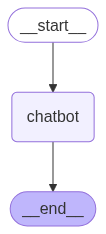

Assistant: LLM stands for **Large Language Model**, a type of artificial intelligence (AI) model designed to understand, generate, and manipulate human-like text. These models are trained on vast amounts of text data using deep learning techniques, particularly transformer architectures (like OpenAI's GPT, Google's PaLM, or Meta's LLaMA).

### Key Features of LLMs:
1. **Scale**: Trained on massive datasets (often terabytes of text from books, articles, code, etc.).
2. **Transformer Architecture**: Uses self-attention mechanisms to process and generate text efficiently.
3. **General-Purpose**: Capable of tasks like answering questions, summarization, translation, coding, and creative writing.
4. **Few-Shot Learning**: Can perform new tasks with minimal examples (prompting).

### Examples of LLMs:
- **GPT-4** (OpenAI)  
- **Gemini** (Google)  
- **Claude** (Anthropic)  
- **LLaMA** (Meta)  

### Applications:
- Chatbots (e.g., ChatGPT)  
- Content creation  
- Programming assistants (e.g

In [ ]:
from typing_extensions import TypedDict

from typing import Annotated
from langchain_deepseek import ChatDeepSeek

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

deepseek_llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [deepseek_llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph? explain in oneline"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break



In [1]:

from langgraph.prebuilt import create_react_agent
from langchain_deepseek import ChatDeepSeek
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage


deepseek_llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Setting up Tools
@tool
def check_email(name:str = None) -> str:
    """Use this tool to get users email address."""
    return "janedoe@example.com"


agent = create_react_agent(deepseek_llm, [check_email])

prompt_template = ChatPromptTemplate([
    ("system", "You are a helpful assistant."),
    MessagesPlaceholder("msgs")
])


prompt_messages = prompt_template.invoke({
    "msgs": [HumanMessage(content="What is Vimal Menon's email address.")]
})

for step in agent.stream(prompt_messages, stream_mode="values"):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Vimal Menon's email address.
================================== Ai Message ==================================
Tool Calls:
  check_email (call_0_0eab14da-e4cd-4a5e-ad95-f739800db06c)
 Call ID: call_0_0eab14da-e4cd-4a5e-ad95-f739800db06c
  Args:
    name: Vimal Menon
================================= Tool Message =================================
Name: check_email

janedoe@example.com
================================== Ai Message ==================================

Vimal Menon's email address is janedoe@example.com.


---
## What is workflow?

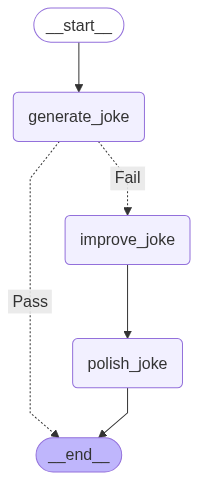

In [2]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

deepseek_llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = deepseek_llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = deepseek_llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = deepseek_llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

from uuid import uui4

In [7]:
from uuid import uuid4

id = uuid4()

config = {"configurable": {"thread_id": id}}
